# Bay Area AirBnB Data: Investigation and Modeling Results

<br> <center> Drew Zinder <br>
    DrewZinder@gmail.com <br>
    August 3, 2022 </center>
    
## Objective
Given a sample of the AirBnB dataset in the San Francisco Bay Area for 2021, help determine factors driving booking rates and total revenue.
    
## General Methodology
* Data is investigated, cleaned, and has factors which could introduce modeling bias removed
* Categorical values are encoded via dummy variables
* Separate models are built to predict both booking rates and annual revenue 
* Feature importance (`total_gain`) illustrated by both XGBoost feature importances, as well as SHAP models, for additional insight

## Conclusions
* ### Booking Model
    * Host Duration was the greatest indicator of booking probability
        * This is not-unexpected, as someone who's been a host with AirBnB for an extended period has likely determined how to best ensure their property is frequently booked
        * Alternatively, however, this could also be due to experienced hosts making their listing unavailable during slower seasons, for personal use or renovation 
    * Maximum stay, price per person, and the price of the listing were all also strongly indicative of booking likelihood
    * Host review and responsiveness elements played a strong role as well, although the number of reviews was more important than the value of those reviews
   
* ### Revenue Model
    * Number of bedrooms was, by far, the most impactful feature in the revenue model
    * Accommodation type and the total accommodation per listing were both impactful as well, with a preference for the entire house / apartment being rented out
    * Number and value of reviews were both fairly important, along with host response variables as well 
    
## Next Steps
* Additional model segmentation could lead to feature-specific insights, at the cost of generality
    * Creating specific sub-models for the following categories could help illustrate unique opportunities:
        * Listings with a per-night price of $1,000 or greater
        * Specific neighborhoods
        * Hosts with a large number of AirBnB properties
* Creating cluster variables for specific amenities (eg, categorizing several types of HDTV together, or multiple categories of luxury toiletries) may reveal additional insights
* Accurate data on when a listing has been booked by a customer or actual revenue values would greatly improve model accuracy, and would allow for the inclusion of additional explanatory variables




## Import Libraries, Set Options, & Load Data

In [23]:
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xgb
import shap

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

# Enable multiple outputs within a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Supress warnings about future feature depreciation 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Supress SHAP depreciation warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [24]:
# Set default values for data visualizations
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15

In [25]:
# Read in data 
listings = pd.read_csv('C:/Users/drewz/Documents/Python Scripts/Data/listings.csv')
calendar = pd.read_csv('C:/Users/drewz/Documents/Python Scripts/Data/calendar.csv')

### Data Type Conversions, Feature Generation

For the purposes of this analysis, we're most interested in both the booking rate for a rental property, and the ultimate revenue received from that booking.  Unfortunately, we don't observe the booking data directly; we're given listing availability (which is `t` when the property is available to be booked, and `f` otherwise.)  

While availability can be used to indicate property bookings, it's also possible for a host to mark a property as unavailable even if it's *not* booked, either for their own personal use, to make improvements or repairs, or even to create a sense of exclusivity for the property.  

As such, while we can use the `available` feature as a proxy for that property being booked, this will lead to positive bias in both the Booking and Revenue models, as well as necessitating dropping other potentially-predictive variables, to prevent data leakage.  

In [26]:
# Convert 'price' to numeric & 'date' to date
calendar['price'] = pd.to_numeric(calendar.price)
calendar['date'] = pd.to_datetime(calendar.date)

# Create proxy variable for whether or not the listing has been booked
calendar['booked_proxy'] = calendar['available'].map({'t':0, 'f':1})

# Create revenue column 
calendar['revenue'] = calendar['price'] * calendar['booked_proxy']

# Check that everything is calculating correctly
calendar.head(10)

,listing_id,date,available,price,booked_proxy,revenue
0,12651,2021-01-04,f,197,1,197
1,12651,2021-01-05,f,197,1,197
2,12651,2021-01-06,f,197,1,197
3,12651,2021-01-07,f,197,1,197
4,12651,2021-01-08,f,197,1,197
5,12651,2021-01-09,f,197,1,197
6,12651,2021-01-10,f,197,1,197
7,12651,2021-01-11,f,197,1,197
8,12651,2021-01-12,t,186,0,0
9,12651,2021-01-13,t,186,0,0


## Data Investigation

array([ 229.,  396.,  586., 1068.])

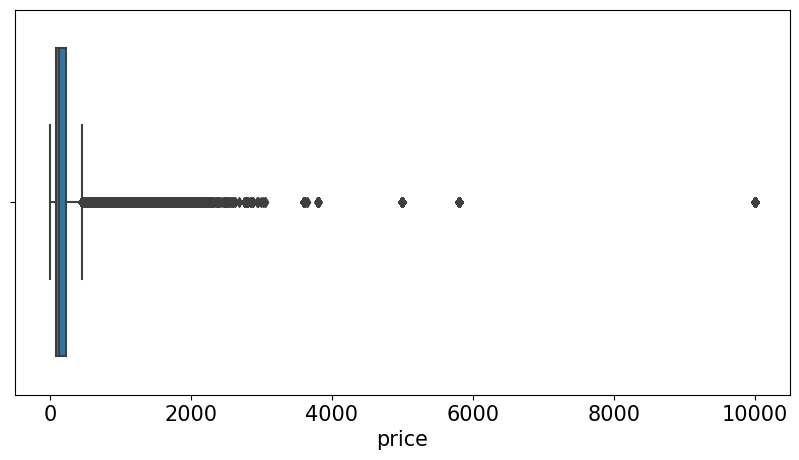

In [27]:
# Data Investigation
ax = sns.boxplot(x = calendar['price'])

# Looks like there are a number of price outliers--75th percentile is $229 per night, and even the 99th percentile is $1,068.  There remains a significant number of listings above this point, however.
np.percentile(calendar.price, [75, 90, 95, 99])

high_price_listings = calendar['listing_id'].loc[calendar.price >= 1000].unique()
# 63 distinct listings above $1000--could definitely skew data and / or modeling

### Observations
* There are some clear outliers in the pricing data: one property in particular, listed at $10,000 a night, as well as several others significantly above the primary mass of data.  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


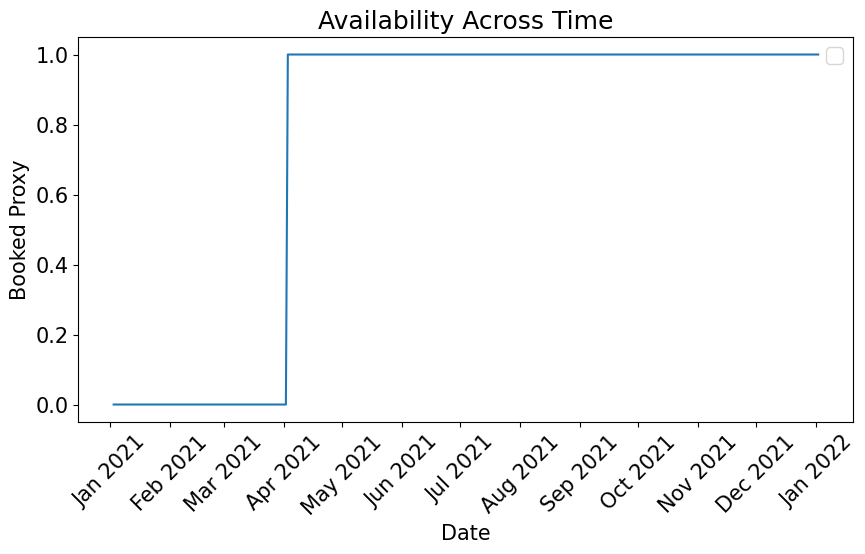

In [28]:
# Graph availability for $10,000-a-night rental

ax = sns.lineplot(x = "date", 
                  y = "booked_proxy", 
                  markers = True, 
                  dashes = True, 
                  data = calendar[calendar['price'] == 10000])

ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation = 45)
plt.title('Availability Across Time')
plt.xlabel('Date')
plt.ylabel('Booked Proxy')
plt.legend(loc='best')

plt.show();

### Observations

* As discussed above, the availability pattern of the $10,000-a-night rental seems to indicate it's been marked as unavailable by the host, rather than this being the result of individual bookings.


## Additional Data Investigations

In [29]:
# Continue to investigate other potential data elements

# Look into people who have multiple listings 
listings[['host_id','id']].groupby('host_id').nunique('id').rename(columns = {'id':'count_listings'}).sort_values(by = 'count_listings', ascending = False).head(10)
# A few superhosts--could also introduce bias or skew. 

# Quick data count check for other variables of interest
data_checklist = ['host_response_time', 'host_is_superhost', 'neighbourhood', 'room_type', 'minimum_nights', 'maximum_nights', 'number_of_reviews']
for val in data_checklist:
    print("Value Counts: " + val)
    listings[val].value_counts().sort_index()

,count_listings
host_id,
48005494,56
43806,31
94282453,24
18839434,21
9419684,20
269221260,19
38163072,19
6017407,17
41574587,16


Value Counts: host_response_time


a few days or more      45
within a day           182
within a few hours     333
within an hour        1572
Name: host_response_time, dtype: int64

Value Counts: host_is_superhost


f    1488
t    1205
Name: host_is_superhost, dtype: int64

Value Counts: neighbourhood


Atherton                 37
Belmont                  60
Brisbane                 24
Burlingame              102
Colma                    10
Daly City               455
East Palo Alto          185
Foster City              55
Half Moon Bay            50
Hillsborough             20
Menlo Park              249
Millbrae                 78
Pacifica                137
Portola Valley            6
Redwood City            228
San Bruno               118
San Carlos               80
San Mateo               288
South San Francisco     166
Unincorporated Areas    316
Woodside                 29
Name: neighbourhood, dtype: int64

Value Counts: room_type


Entire home/apt    1571
Hotel room            3
Private room        980
Shared room         139
Name: room_type, dtype: int64

Value Counts: minimum_nights


1      900
2      653
3      319
4      101
5      105
6        9
7       90
9        2
10      19
12       3
13       1
14      53
15      29
16       1
18       1
20      21
21       5
22       1
23       1
25       9
27       2
28      24
29       7
30     243
31      43
35       1
45       2
58       1
60       8
80       1
90      24
100      6
110      1
120      1
180      3
183      1
365      2
Name: minimum_nights, dtype: int64

Value Counts: maximum_nights


1           4
2          10
3          17
4          10
5          23
         ... 
1024        1
1111       10
1124        9
1125     1345
10000       1
Name: maximum_nights, Length: 88, dtype: int64

Value Counts: number_of_reviews


0      400
1      172
2      116
3       73
4       67
      ... 
576      1
585      1
597      1
624      1
711      1
Name: number_of_reviews, Length: 307, dtype: int64

### Observations:
* While most variables look roughly as expected, there is a surprising number of listings where the `maximum_nights` variable is 1125.  This doesn't seem to divide cleanly into weeks / months / years--there may be some element in the AirBnB hosting process that's causing this.  
* There are two distinct listings that have minimum stays of one year.  They seem to be otherwise unremarkable, but may also introduce skew into the modeling process.  

In [30]:
# Continue to investigate potential data anamolies 

# Look into minimum_nights == 365 further--do they have 365 availability? 
listings[listings['minimum_nights'] == 365]
# They do, which is good.  Still, should perhaps pull these from the dataset.  

# Look into host_id where maximum_nights == 1125.  Maybe all one host?  
listings[['host_id', 'id']][listings['maximum_nights'] == 1125].groupby('host_id').nunique('id').sort_values(by = 'id', ascending = False)

,id,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_identity_verified,...,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_365,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month
352,8802212,46123157,Erik,10/9/15,NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,...,1.0,"[""Smoke alarm"", ""Air conditioning"", ""Dedicated...",365,1125,t,365,2,100.0,f,0.04
693,17174321,115544213,Yu,2/8/17,NaN,NaN,NaN,f,"['email', 'phone', 'reviews']",f,...,6.0,"[""Refrigerator"", ""Hot water"", ""Bathtub"", ""Dish...",365,1125,t,365,56,92.0,t,1.19


,id
host_id,
48005494,56
43806,30
18839434,21
9419684,20
269221260,19
...,...
33113726,1
33528866,1
33533549,1


## Data Cleaning
* Removing listings above the 99th percentile for price
* Removing listings that require a full year for the minimum stay

In [31]:
# Excluding listings where price > 99th percentile ($1,068)
calendar_trimmed = calendar[calendar['price'] <= 1068].sort_values(by = 'price', ascending = False)

# Excluding listings where minimum_nights == 365
listings_trimmed = listings[listings['minimum_nights'] < 365].sort_values(by = 'minimum_nights', ascending = False)

# Check 
calendar_trimmed.head()
listings_trimmed.head()

,listing_id,date,available,price,booked_proxy,revenue
882805,41161684,2021-08-20,t,1068,0,0
882736,41161684,2021-06-12,t,1068,0,0
480148,45801349,2021-06-20,t,1068,0,0
887184,41354919,2021-08-21,t,1068,0,0
887114,41354919,2021-06-12,t,1068,0,0


,id,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_identity_verified,...,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_365,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month
1248,26899268,96454054,Zhang,9/23/16,NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'off...",t,...,1.0,"[""Smoke alarm"", ""Dryer"", ""Hot water"", ""Kitchen...",183,365,t,365,0,NaN,t,NaN
385,9524006,37850778,Li,7/8/15,within a day,100%,NaN,t,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,...,4.0,"[""Piano"", ""Refrigerator"", ""Heating"", ""BBQ gril...",180,365,t,358,5,100.0,f,0.08
2053,39845390,77543039,Ravikumar,6/13/16,NaN,NaN,NaN,f,"['email', 'phone', 'kba']",t,...,1.0,"[""Long term stays allowed"", ""Kitchen"", ""Dedica...",180,365,t,364,0,NaN,f,NaN
2133,40662252,42735987,Ivy,8/28/15,NaN,NaN,NaN,f,"['email', 'phone', 'offline_government_id', 's...",t,...,1.0,"[""Smoke alarm"", ""Waterfront"", ""Heating"", ""Carb...",180,1125,t,365,0,NaN,t,NaN
2491,45517112,10666699,Cedric,12/17/13,NaN,NaN,NaN,f,"['phone', 'reviews', 'jumio', 'government_id']",t,...,2.0,"[""Wifi"", ""Shampoo"", ""First aid kit"", ""Essentia...",120,151,t,86,0,NaN,f,NaN


## Investigation of Average Daily Price for Trimmed Data

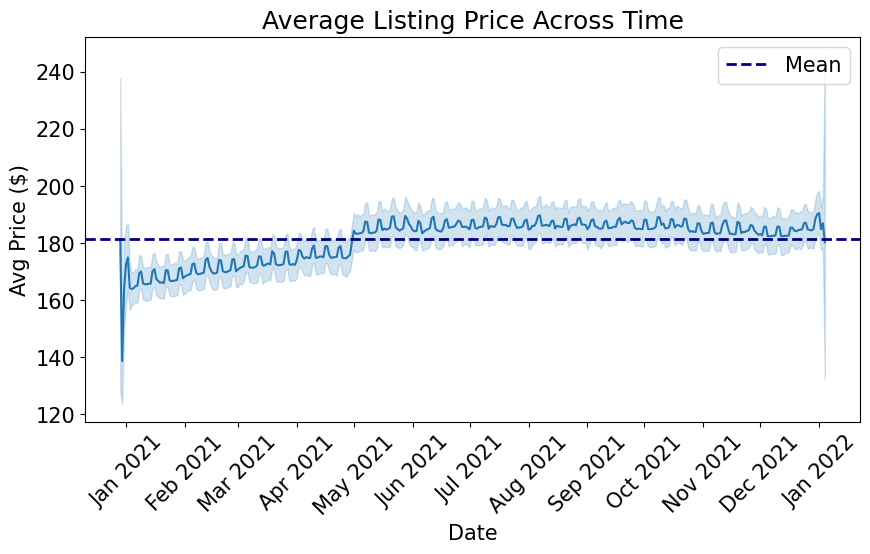

In [32]:
# Create graph of average daily price
ax = sns.lineplot(x = "date", 
                  y = "price", 
                  markers = True, 
                  dashes = True, 
                  data = calendar_trimmed)

ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.axhline(calendar_trimmed['price'].mean(), color='navy', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Average Listing Price Across Time')
plt.xlabel('Date')
plt.ylabel('Avg Price ($)')
plt.legend(loc='best')

plt.show();

In [33]:
# Large spikes in price in January (both 2021 and 2022), and a persistent increase in May.  Investigating further. 

calendar_trimmed[['date', 'price']].groupby('date').mean()

# somewhat-large drop on 21-12-30, but price recovers fairly quickly.  Lot of variation at the end of December / beginning of January.
# Avg price also goes from ~mid-170 per night prior to 05-01-21 to ~mid-to-upper-180 afterwards.  Would expect this to be a temporary increase for summer, but it seems to be persistent.  Some sort of structural change?  
# Additional exploration--look at data by neighborhood, room_type?  

,price
date,
2020-12-29,180.875000
2020-12-30,138.686567
2020-12-31,163.723270
2021-01-01,172.501938
2021-01-02,175.036601
...,...
2021-12-31,190.156863
2022-01-01,190.609688
2022-01-02,184.933754


### Observations
* High variation in price in January of both years.  Likely due to holiday or seasonal effects. 
* Price trends generally upward from January to April, with a significant uptick at the beginning of May, likely also due to seasonal effects.  Price starts to trend back downwards (albeit slowly) in the fall.  
* Price also indicates presence of weekly trends, with minor (but consistent) price increases for weekend dates.
* At a glance, price appears to be [stationary](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322).  (Booking rates, by definition, are stationary as well.)  As such, we can build models for average annual values of both, which allows the use of XGBoost without concerns about the longitudinal nature of the data.  

## Removing Special Characters

In [34]:
# Remove the following special characters in both 'host_verifications' & 'amenities' columns: [ ] ' " \
# Additionally, remove unicode character artifacts: 'u2019', 'u2013', 'u00a0'

# 'amenities' column:
listings_trimmed['amenities'] = listings_trimmed['amenities'].str.replace('[', '') \
    .str.replace(']', '') \
    .str.replace('"', '') \
    .str.replace('\\', '') \
    .str.replace('u2019', '') \
    .str.replace('u2013', '') \
    .str.replace('u00a0', '') 


# 'host_verifications' column:
listings_trimmed['host_verifications'] = listings_trimmed['host_verifications'].str.replace('[', '') \
    .str.replace(']', '') \
    .str.replace("'", "") \
    .str.replace('\\', '')


# Check replacements
listings_trimmed[['host_verifications', 'amenities']].head()

,host_verifications,amenities
1248,"email, phone, facebook, reviews, offline_gover...","Smoke alarm, Dryer, Hot water, Kitchen, Wifi, ..."
385,"email, phone, reviews, jumio, selfie, governme...","Piano, Refrigerator, Heating, BBQ grill, Hair ..."
2053,"email, phone, kba","Long term stays allowed, Kitchen, Dedicated wo..."
2133,"email, phone, offline_government_id, selfie, g...","Smoke alarm, Waterfront, Heating, Carbon monox..."
2491,"phone, reviews, jumio, government_id","Wifi, Shampoo, First aid kit, Essentials, TV, ..."


## Data Cleaning, One-Hot Encoding

In [35]:
# Remove '%' sign from host_response_rate, host_acceptance_rate &
numeric_cols = ['host_response_rate', 'host_acceptance_rate']
for col in numeric_cols:
    listings_trimmed[col] = listings_trimmed[col].str.replace('%', '')
    listings_trimmed[col] = pd.to_numeric(listings_trimmed[col], errors = 'coerce')/100

# Map boolean columns to 0 1
# Couldn't get the map funciton to work with apply or in a loop--this is inelegant, but it'll work.  
listings_trimmed['host_is_superhost'] = listings_trimmed['host_is_superhost'].map({'f':0, 't':1})
listings_trimmed['host_identity_verified'] = listings_trimmed['host_identity_verified'].map({'f':0, 't':1})
listings_trimmed['has_availability'] = listings_trimmed['has_availability'].map({'f':0, 't':1})
listings_trimmed['instant_bookable'] = listings_trimmed['instant_bookable'].map({'f':0, 't':1})

# Convert host_since column numeric, by calculating difference between host_since & last date in the dataset
listings_trimmed['host_duration'] = (calendar['date'].max() - pd.to_datetime(listings_trimmed.host_since)).dt.days  
    
# Check data conversions
listings_trimmed.head()

,id,host_id,host_name,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_identity_verified,...,amenities,minimum_nights,maximum_nights,has_availability,availability_365,number_of_reviews,review_scores_rating,instant_bookable,reviews_per_month,host_duration
1248,26899268,96454054,Zhang,9/23/16,NaN,NaN,NaN,0,"email, phone, facebook, reviews, offline_gover...",1,...,"Smoke alarm, Dryer, Hot water, Kitchen, Wifi, ...",183,365,1,365,0,NaN,1,NaN,1929
385,9524006,37850778,Li,7/8/15,within a day,1.0,NaN,1,"email, phone, reviews, jumio, selfie, governme...",1,...,"Piano, Refrigerator, Heating, BBQ grill, Hair ...",180,365,1,358,5,100.0,0,0.08,2372
2053,39845390,77543039,Ravikumar,6/13/16,NaN,NaN,NaN,0,"email, phone, kba",1,...,"Long term stays allowed, Kitchen, Dedicated wo...",180,365,1,364,0,NaN,0,NaN,2031
2133,40662252,42735987,Ivy,8/28/15,NaN,NaN,NaN,0,"email, phone, offline_government_id, selfie, g...",1,...,"Smoke alarm, Waterfront, Heating, Carbon monox...",180,1125,1,365,0,NaN,1,NaN,2321
2491,45517112,10666699,Cedric,12/17/13,NaN,NaN,NaN,0,"phone, reviews, jumio, government_id",1,...,"Wifi, Shampoo, First aid kit, Essentials, TV, ...",120,151,1,86,0,NaN,0,NaN,2940


In [36]:
# Create dummy variables for 'host_verification', 'amenities' columns

# 'host_verifications' dummies 
host_verifications_dummies = pd.get_dummies(listings_trimmed['host_verifications'].str.split(',').explode(), prefix = 'host_verification').sum(level=0)

# 'amenities' dummies
amenities_dummies = pd.get_dummies(listings_trimmed['amenities'].str.split(',').explode(), prefix = 'amenity').sum(level=0)

# 'host_response_time', 'neighbourhood', 'room_type' dummies
host_response_time_dummies = pd.get_dummies(listings_trimmed['host_response_time'], prefix = 'response_time')
neighbourhood_dummies = pd.get_dummies(listings_trimmed['neighbourhood'], prefix = 'neighbourhood')
room_type_dummies = pd.get_dummies(listings_trimmed['room_type'], prefix = 'room_type')

# Host ID dummies--may be useful if there's trends around superhosts
host_id_dummies = pd.get_dummies(listings_trimmed['room_type'], prefix = 'host_id')

# Check the dummy variable dataframes
host_verifications_dummies.head()
amenities_dummies.head()

,host_verification_ facebook,host_verification_ google,host_verification_ government_id,host_verification_ identity_manual,host_verification_ jumio,host_verification_ kba,host_verification_ manual_offline,host_verification_ manual_online,host_verification_ offline_government_id,host_verification_ phone,...,host_verification_ sent_id,host_verification_ sesame,host_verification_ sesame_offline,host_verification_ weibo,host_verification_ work_email,host_verification_ zhima_selfie,host_verification_email,host_verification_kba,host_verification_manual_online,host_verification_phone
1248,1,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
385,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
2053,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2133,0,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
2491,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,amenity_,amenity_ 15 TV,amenity_ 19 TV with standard cable,amenity_ 32 HDTV with Amazon Prime Video,amenity_ 32 HDTV with Netflix,amenity_ 48 HDTV,amenity_ 5 cf (small) with very little freezer. ( see photo in listing) refrigerator,amenity_ 50 HDTV with Netflix,amenity_ 55 HDTV with Netflix,amenity_ 55 TV with Netflix,...,amenity_Shower gel,amenity_Single level home,amenity_Smoke alarm,amenity_Stove,amenity_TV,amenity_Toiletries,amenity_Washer,amenity_Waterfront,amenity_Wifi,amenity_Window guards
1248,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2133,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2491,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Merge Dummy Variable Dataframes onto `listings_trimmed`

In [37]:
# Set up & use the reduce functionality for multiple merges 
data_frames = [listings_trimmed, host_verifications_dummies, amenities_dummies, host_response_time_dummies, neighbourhood_dummies, room_type_dummies, host_id_dummies]
listings_w_dummies = reduce(lambda left, right: pd.merge(left, right, left_index = True, right_index = True, how = 'left'), data_frames)

# Drop previously-encoded columns columns
listings_w_dummies.drop(['host_since', 'host_verifications', 'amenities', 'host_response_time', 'neighbourhood', 'room_type', 'host_id'], axis = 1, inplace= True)

# Check merge
listings_w_dummies.head()


,id,host_name,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,...,neighbourhood_Unincorporated Areas,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_id_Entire home/apt,host_id_Hotel room,host_id_Private room,host_id_Shared room
1248,26899268,Zhang,NaN,NaN,0,1,1,1.0,1.0,183,...,0,0,0,0,1,0,0,0,1,0
385,9524006,Li,1.0,NaN,1,1,4,3.0,4.0,180,...,0,0,1,0,0,0,1,0,0,0
2053,39845390,Ravikumar,NaN,NaN,0,1,1,1.0,1.0,180,...,0,0,0,0,1,0,0,0,1,0
2133,40662252,Ivy,NaN,NaN,0,1,1,1.0,1.0,180,...,0,0,1,0,0,0,1,0,0,0
2491,45517112,Cedric,NaN,NaN,0,1,3,2.0,2.0,120,...,0,0,1,0,0,0,1,0,0,0


In [38]:
# Price seemed to be largely stationary.  Model based on annual averages for booking, price, and revenue.  

# Create average values for booked_proxy, price, revenue
calendar_avg = pd.DataFrame()
avg_cols = ['booked_proxy', 'price', 'revenue']
for col in avg_cols:
    col_name = 'avg_' + col
    calendar_avg.loc[:, col_name] = calendar_trimmed.groupby('listing_id').mean()[col]

# Merge tables into single dataframe
all_data = pd.merge(calendar_avg, 
                    listings_w_dummies, 
                    how = 'left', 
                    left_on = 'listing_id', 
                    right_on = 'id')

# Check to make sure merge executed correctly
all_data.head()

,avg_booked_proxy,avg_price,avg_revenue,id,host_name,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,accommodates,...,neighbourhood_Unincorporated Areas,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_id_Entire home/apt,host_id_Hotel room,host_id_Private room,host_id_Shared room
0,0.024658,211.073973,4.917808,12651.0,Laurel,1.0,0.98,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.000000,120.000000,0.000000,39342.0,Annette,1.0,0.40,0.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.000000,110.000000,0.000000,40560.0,Megan,NaN,0.48,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.509589,210.000000,107.013699,44504.0,Maggie,1.0,1.00,1.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.515068,145.000000,74.684932,45287.0,Diane And Mike,1.0,0.94,1.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Create additional features for Booking model

In [39]:
# Create additional features for predicting bookings

all_data['price_per_person'] = all_data['avg_price'] / all_data['accommodates']
all_data['bedrooms_per_person'] = all_data['bedrooms'] / all_data['accommodates']

## Test / Train Split for Booking & Revenue models

The data used to both train and evaluate each model should be the same, excluding specific variables that are able to be included in the Booking model but not the Revenue model, due to data leakage.  

In [40]:
# Create test / train split

# Variables to drop (to prevent data leakage) for predicting bookings, revenue:
x_drop_book = ['avg_booked_proxy', 'avg_revenue', 'host_name', 'has_availability', 'availability_365', 'id']
x_drop_rev = ['avg_booked_proxy', 'avg_price', 'avg_revenue', 'price_per_person', 'bedrooms_per_person', 'host_name', 'has_availability', 'availability_365', 'id']

# Test / train split for bookings & revenue models
x_train_book, x_test_book, y_train_book, y_test_book = train_test_split(all_data.drop(x_drop_book, axis = 1), 
                                                                        all_data['avg_booked_proxy'],
                                                                        test_size = 0.25, 
                                                                        random_state = 0
                                                                        )

x_train_rev, x_test_rev, y_train_rev, y_test_rev = train_test_split(all_data.drop(x_drop_rev, axis = 1), 
                                                                    all_data['avg_revenue'],
                                                                    test_size = 0.25, 
                                                                    random_state = 0
                                                                    )

# Check data
x_train_rev.head()
y_train_rev.head()
x_test_rev.shape
y_test_rev.shape

,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,...,neighbourhood_Unincorporated Areas,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_id_Entire home/apt,host_id_Hotel room,host_id_Private room,host_id_Shared room
2358,1.00,0.95,1.0,1.0,6.0,3.0,3.0,2.0,10.0,22.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2489,0.97,0.99,0.0,1.0,12.0,3.0,6.0,1.0,365.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
587,1.00,0.88,0.0,1.0,4.0,1.0,2.0,25.0,28.0,145.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1918,NaN,NaN,0.0,1.0,2.0,1.0,1.0,1.0,1125.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1368,1.00,0.99,1.0,1.0,2.0,1.0,1.0,1.0,21.0,115.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


2358    474.657534
2489      7.052055
587      72.931507
1918     56.712329
1368     81.241096
Name: avg_revenue, dtype: float64

(669, 398)

(669,)

## Model Building with XGBoost

In [41]:
# Initialize XGBoost model
xgb_reg = xgb.XGBRegressor(random_state = 0)

### Hyperparameter Tuning

In [42]:
# Create ranges for hyperparameter tuning
n_estimators = np.arange(100, 1000, 100)
max_depth = np.arange(5, 25, 2)
min_child_weight = np.arange(1, 10, 1)

# Create the grid for hyperparameter tuning
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight
              }

### Random Search for Booking & Revenue models

In [43]:
# Initialize the random search, based off the values above
xgb_random = RandomizedSearchCV(estimator = xgb_reg, 
                               param_distributions = random_grid,
                               n_iter = 100, 
                               scoring = 'neg_mean_squared_error',
                               cv = 5, 
                               n_jobs = -1,
                               random_state = 0,
                               return_train_score = True)

In [44]:
# Search over previously-initialized parameters
xgb_random.fit(x_train_book, y_train_book)

# Return the parameters that minimized MSE
print("Booking Model Random Search Parameters & MSE:")
xgb_random.best_params_

# Report MSE of best random-search model
predict = xgb_random.predict(x_test_book)
mse = MSE(y_test_book, predict)
print("MSE: % f" %(mse))

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=0,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=0, return_train_score=True,
                   scoring='neg_mean_squared_error')

Booking Model Random Search Parameters & MSE:


{'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 11}

MSE:  0.106841


In [45]:
# Repeat for revenue model
xgb_random.fit(x_train_rev, y_train_rev)

# Return the parameters that minimized MSE
print("Revenue Model Random Search Parameters & MSE:")
xgb_random.best_params_

# Report MSE of best random-search model
predict = xgb_random.predict(x_test_rev)
mse = MSE(y_test_rev, predict)
print("MSE: % f" %(mse))

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=0,
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900])},
                   random_state=0, return_train_score=True,
                   scoring='neg_mean_squared_error')

Revenue Model Random Search Parameters & MSE:


{'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 5}

MSE:  10472.249708


### Grid Search around specific points identified in Random Search, above

In [46]:
# Initialize grid search around best parameters from random search, above
parameter_grid_book = {'n_estimators': [400, 450, 500, 550, 600],
                       'max_depth': [9, 10, 11, 12, 13],
                       'min_child_weight': [1, 2, 3, 4], 
                       'random_state': [0]
                      }

xgb_grid_book = GridSearchCV(estimator = xgb_reg, 
                             param_grid = parameter_grid_book,
                             scoring = 'neg_mean_squared_error',
                             cv = 5, 
                             n_jobs = -1,
                             return_train_score = True)

In [47]:
# Repeat process for revenue model
parameter_grid_rev = {'n_estimators': [150, 200, 250, 300, 350, 400],
                      'max_depth': [3, 4, 5, 6, 7],
                      'min_child_weight': [1, 2, 3, 4, 5], 
                      'random_state': [0]
                     }

xgb_grid_rev = GridSearchCV(estimator = xgb_reg, 
                            param_grid = parameter_grid_rev,
                            scoring = 'neg_mean_squared_error',
                            cv = 5, 
                            n_jobs = -1,
                            return_train_score = True)

In [48]:
# Search over previously-initialized parameters
xgb_grid_book.fit(x_train_book, y_train_book)

# Return the parameters that minimized MSE
print("Booking Model Grid Search Parameters & MSE:")
xgb_grid_book.best_params_

# Report MSE of best random-search model
predict = xgb_grid_book.predict(x_test_book)
mse = MSE(y_test_book, predict)
print("MSE: % f" %(mse))

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [9, 10, 11, 12, 13],
                         'min_child_weight': [1, 2, 3, 4],
                         'n_estimators': [400, 450, 500, 550, 600],
                         'random_state': [0]},
             return_train_score=True, scoring='neg_mean_squared_error')

Booking Model Grid Search Parameters & MSE:


{'max_depth': 10,
 'min_child_weight': 1,
 'n_estimators': 400,
 'random_state': 0}

MSE:  0.103257


In [49]:
# Repeat process for revenue model
xgb_grid_rev.fit(x_train_rev, y_train_rev)

# Return the parameters that minimized MSE
print("Revenue Model Grid Search Parameters & MSE:")
xgb_grid_rev.best_params_

# Report MSE of best random-search model
predict = xgb_grid_rev.predict(x_test_rev)
mse = MSE(y_test_rev, predict)
print("MSE: % f" %(mse))

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [150, 200, 250, 300, 350, 400],
                         'random_state': [0]},
             return_train_score=True, scoring='neg_mean_squared_error')

Revenue Model Grid Search Parameters & MSE:


{'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'random_state': 0}

MSE:  10663.771560


In [50]:
# Initialize full booking model, using the parameters identified during the grid search.
xgb_full_book = xgb.XGBRegressor(n_estimators = xgb_grid_book.best_params_['n_estimators'],
                                 max_depth = xgb_grid_book.best_params_['max_depth'],
                                 min_child_weight = xgb_grid_book.best_params_['min_child_weight']
                                 )

# Fit the full model
xgb_full_book.fit(x_train_book, y_train_book)

# Report MSE of full model
predict = xgb_full_book.predict(x_test_book)
mse = MSE(y_test_book, predict)
print("Booking Model MSE: % f" %(mse))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Booking Model MSE:  0.103257


In [51]:
# Initialize full revenue model, using the parameters identified during the grid search
xgb_full_rev = xgb.XGBRegressor(n_estimators = xgb_grid_rev.best_params_['n_estimators'],
                                max_depth = xgb_grid_rev.best_params_['max_depth'],
                                min_child_weight = xgb_grid_rev.best_params_['min_child_weight']
                               )

# Fit the full model
xgb_full_rev.fit(x_train_rev, y_train_rev)

# Report MSE of full model
predict = xgb_full_rev.predict(x_test_rev)
mse = MSE(y_test_rev, predict)
print("Revenue Model MSE: % f" %(mse))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Revenue Model MSE:  10663.771560


### Observations
* For both the Booking and Revenue models, better performance was achieved by selecting more conservative hyperparameters. 
* While slightly surprising, this is not unexpected--given the number of dummy variables created from the different categorical variables (`amenities` in particular), it would be very easy to overfit these models.  More conservative hyperparameters seems to be a good choice.  



## Feature Importance

Having created models for both booking rates and revenue, examining feature importance will help illustrate what variables most influence booking probability and total revenue, respectively.  

<Figure size 1200x1000 with 0 Axes>

<Axes: xlabel='Importance', ylabel='Feature'>

Text(0.5, 1.0, 'Feature Importance for Booking Model')

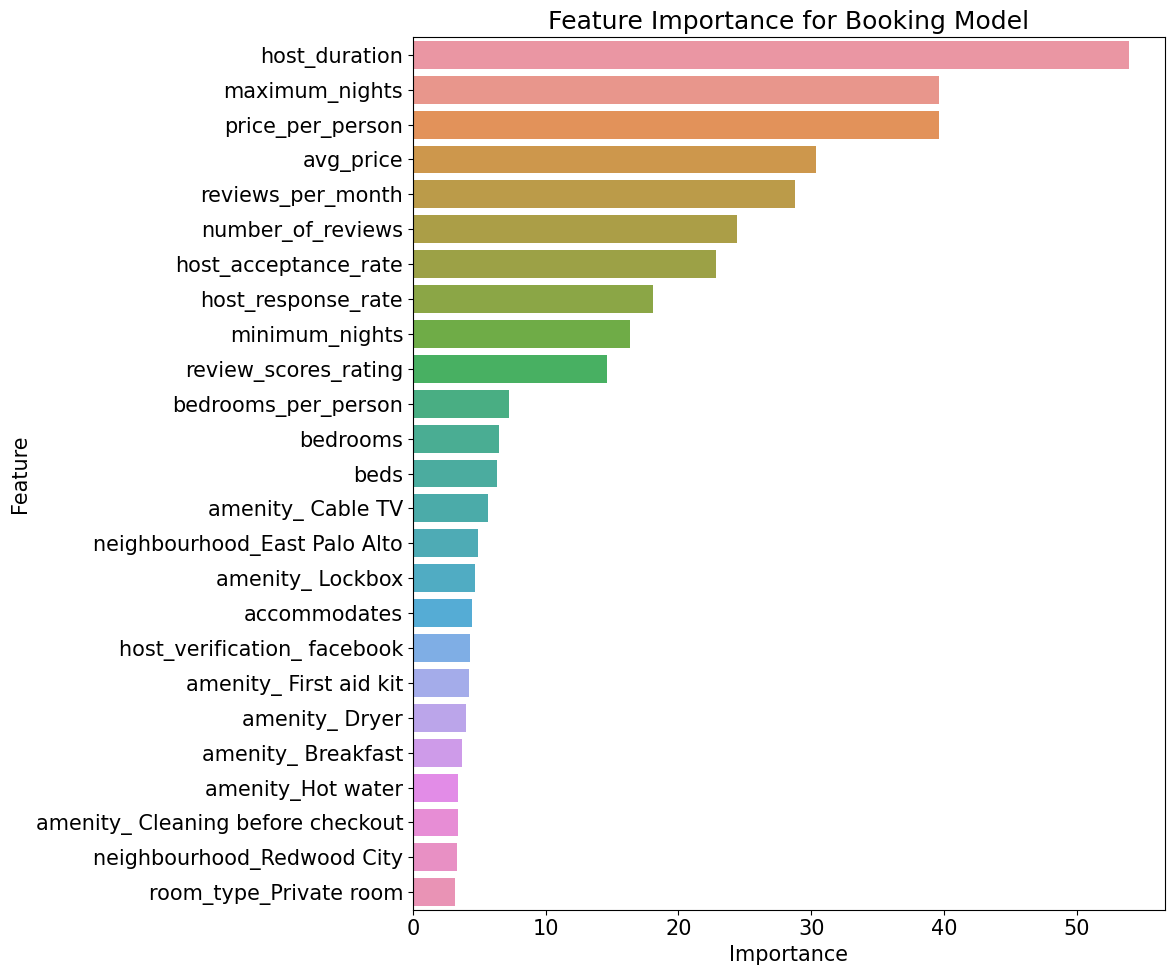

<Figure size 1200x1000 with 0 Axes>

<Axes: xlabel='Importance', ylabel='Feature'>

Text(0.5, 1.0, 'Feature Importance for Revenue Model')

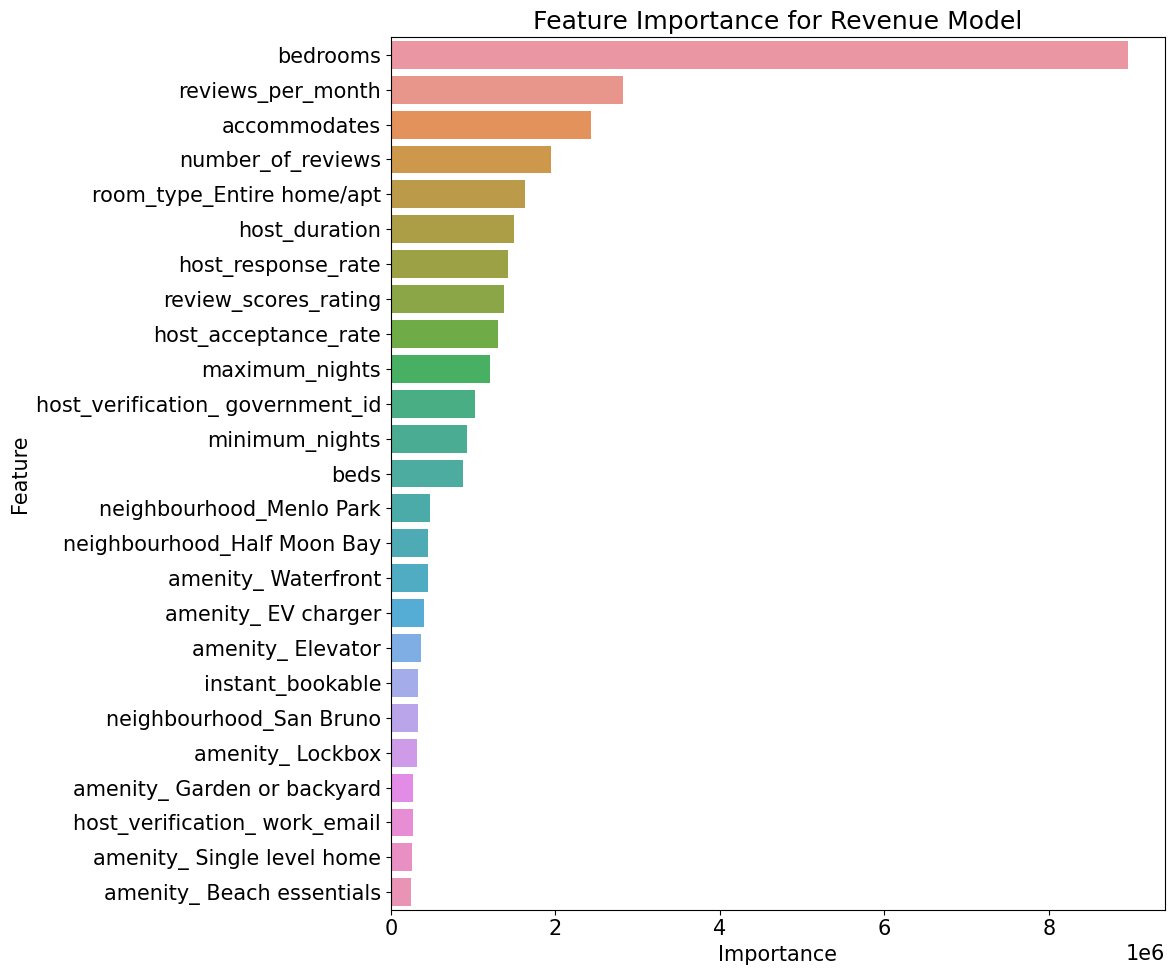

In [52]:
# Identify feature importance for booking, revenue models
xgb_features_book = pd.DataFrame(xgb_full_book.get_booster().get_score(fmap='', importance_type='total_gain'), index = [0])
top_features_book = pd.melt(xgb_features_book).rename(columns = {'variable': 'Feature', 'value':'Importance'}).sort_values(by = 'Importance', ascending = False)[:25]

xgb_features_rev = pd.DataFrame(xgb_full_rev.get_booster().get_score(fmap='', importance_type='total_gain'), index = [0])
top_features_rev = pd.melt(xgb_features_rev).rename(columns = {'variable': 'Feature', 'value':'Importance'}).sort_values(by = 'Importance', ascending = False)[:25]

# Graph feature importance 
plt.figure(figsize=(12,10))
sns.barplot(x="Importance",
            y="Feature",
            data=top_features_book)
plt.title('Feature Importance for Booking Model')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,10))
sns.barplot(x="Importance",
            y="Feature",
            data=top_features_rev)
plt.title('Feature Importance for Revenue Model')
plt.tight_layout()
plt.show()

### SHAP helps illustrate feature directionality

While the feature importance can tell us **which** variables most influenced a model, the SHAP library provides a notable additional feature: directionality.  For many variables, it's fairly intuitive how a feature impacts the final prediction--an increase in price tends to lead to a decrease in bookings, generally. For some, however, it's not immedietly apparent: in predicting revenue, for example, an increase in price may lead to a decrease in bookings, **but** will lead to greater revenue per booking--which effect ultimately wins out?  The SHAP library helps resolve this issue by providing feature directionality in a concise graphical format. 

Unfortunately, the latest version of SHAP is out of date, and incompatiable with numpy > 1.24.  SHAP functionality disabled for the time being.  

In [ ]:
# SHAP functionality currently not availble; disabled for the time being. 

# Use SHAP (SHapley Additive exPlanations) for feature importance directionality

# import shap

# SHAP for first entry in booking model
# explainer_book = shap.TreeExplainer(xgb_full_book)
# shap_values_book = explainer_book.shap_values(x_test_book)
# shap.plots.waterfall(explainer_book[0], show = False)
# plt.title("Sample Feature Importance Explanation, Booking Model")
# plt.show()

# SHAP for first entry in revenue model
# explainer_rev = shap.Explainer(xgb_full_rev)
# shap_values_rev = explainer_rev(x_test_rev)
# shap.plots.waterfall(shap_values_rev[0], show = False)
# plt.title("Sample Feature Importance Explanation, Revenue Model")
# plt.show()

### Important Caveat

* SHAP models variable importance on an individual, rather than aggregate, level.  Feature importances illustrated above are for the first record in the dataset.  